# Segmentación de clientes

In this project, we explore the dynamic world of online retail by examining a transactional dataset from a UK-based retailer, sourced from the UCI Machine Learning Repository.

### Opportunity

The dataset encompasses transactions recorded between 2010 and 2011. Our main goal is to enhance marketing effectiveness and increase sales through customer segmentation. To achieve this, we transform the raw transactional data into a customer-focused format by engineering new features that support the identification of distinct customer segments using clustering algorithms.

This segmentation enables us to uncover unique customer profiles and gain insights into their behaviors and preferences.



### **Dataset Description:**

The dataset consist of 541,909 entries and 8 columns.

| **Column**    | **Description**                                                                                   |
|----------------|---------------------------------------------------------------------------------------------------|
| Invoice        | Code representing each unique transaction. If this code starts with letter 'C', it indicates a cancellation. |
| StockCode      | Code uniquely assigned to each distinct product.                                                  |
| Description    | Description of each product.                                                                      |
| Quantity       | The number of units of a product in a transaction.                                                |
| InvoiceDate    | The date and time of the transaction.                                                             |
| Price          | The unit price of the product in sterling.                                                        |
| Customer ID     | Identifier uniquely assigned to each customer.                                                   |
| Country        | The country where each transaction took place.                                                   |


## Setup and Initialization

In [751]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotly.offline import iplot

import warnings
warnings.filterwarnings('ignore')

## Initial Data Analysis

In [752]:
# Load the dataset and dataset overview
df = pd.read_excel('online_retail_II.xlsx', sheet_name='Year 2010-2011')
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [753]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      541910 non-null  object        
 1   StockCode    541910 non-null  object        
 2   Description  540456 non-null  object        
 3   Quantity     541910 non-null  int64         
 4   InvoiceDate  541910 non-null  datetime64[ns]
 5   Price        541910 non-null  float64       
 6   Customer ID  406830 non-null  float64       
 7   Country      541910 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


## Data Cleaning and Transformation

### Handling Missing values

In [754]:
# Percetage of missing values
missing_percentage = df[['Customer ID', 'Description']].isnull() \
    .mean() * 100

missing_percentage

Customer ID    24.926648
Description     0.268310
dtype: float64

In [755]:
# Saving the missing values to a CSV file
missing_values = df[['Customer ID', 'Description']].isnull().to_csv('missing_values.csv', index=False)

# Drop missing values
df.dropna(inplace = True)

**Customer ID (24.93% missing values) and Description (0.27% missing values)** 
- Both columns are essential for clustering customers. Therefore, missing values in the dataset are removed.

### Handling Duplicates

In [756]:
# Displaying the number of duplicate rows
print(f"The dataset contains {df.duplicated().sum()} duplicate rows that need to be removed.")

The dataset contains 5225 duplicate rows that need to be removed.


In [757]:
# Drop duplicated rows
df.drop_duplicates(inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 401605 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      401605 non-null  object        
 1   StockCode    401605 non-null  object        
 2   Description  401605 non-null  object        
 3   Quantity     401605 non-null  int64         
 4   InvoiceDate  401605 non-null  datetime64[ns]
 5   Price        401605 non-null  float64       
 6   Customer ID  401605 non-null  float64       
 7   Country      401605 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.6+ MB


**10,062 Duplicates rows**
- The presence of identical transaction times, suggests that these might be data recording errors rather than genuine repeated transactions. Therefore, duplicate rows must be removed.

### Identifying Stock Codes

In [758]:
# Number of unique StockCodes
nunique_stock_codes = df['StockCode'].nunique()
print(f"Number of unique StockCodes: {nunique_stock_codes}")

Number of unique StockCodes: 3684


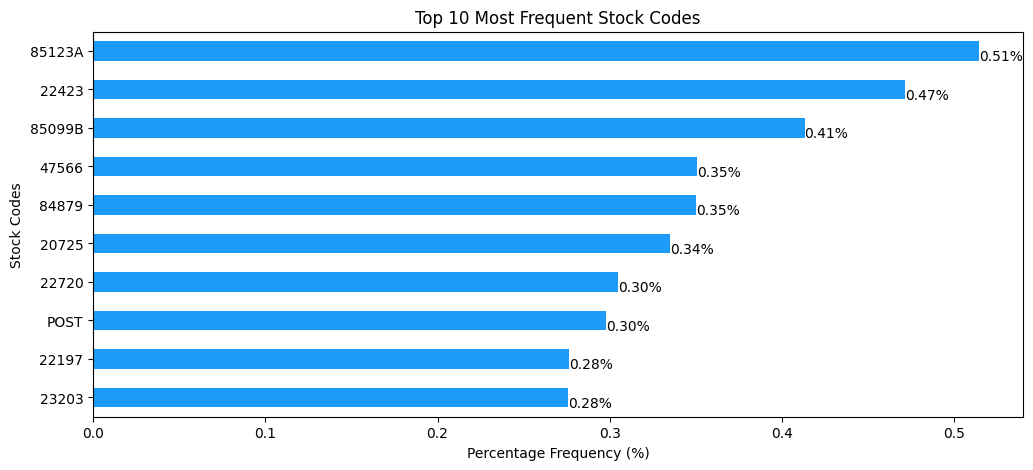

In [759]:
# Finding the top 10 most frequent stock codes
top_10_stock_codes = df['StockCode'].value_counts(normalize=True).head(10) * 100

# Plotting the top 10 most frequent stock codes
plt.figure(figsize=(12, 5))
top_10_stock_codes.plot(kind='barh', color='#1C9BF9')

# Adding the percentage frequency on the bars
for index, value in enumerate(top_10_stock_codes):
    plt.text(value, index+0.25, f'{value:.2f}%', fontsize=10)

plt.title('Top 10 Most Frequent Stock Codes')
plt.xlabel('Percentage Frequency (%)')
plt.ylabel('Stock Codes')
plt.gca().invert_yaxis()
plt.show()

In [760]:
# Values of numeric characteres in unique stock codes
unique_stock_codes = df['StockCode'].unique()
numeric_char_counts_in_unique_codes = pd.Series(unique_stock_codes).apply(lambda x: sum(c.isdigit() for c in str(x))).value_counts()
numeric_char_counts_in_unique_codes

5    3676
0       7
1       1
Name: count, dtype: int64

In [761]:
# Anomalous stock codes
anomalous_stock_codes = [code for code in unique_stock_codes if sum(c.isdigit() for c in str(code)) in (0, 1)]

for code in anomalous_stock_codes:
    print(code)

POST
D
C2
M
BANK CHARGES
PADS
DOT
CRUK


In [762]:
# Calculating the percentage of records with anomalous stock codes
percentage_anomalous_stock_codes = len(df[df['StockCode'].isin(anomalous_stock_codes)]) / len(df) * 100
print(f"Percentage of records with anomalous stock codes: {percentage_anomalous_stock_codes:.2f}%")

Percentage of records with anomalous stock codes: 0.48%


In [763]:
# Removing rows with anomalous stock codes
df = df[~df['StockCode'].isin(anomalous_stock_codes)]

len(df)

399689

### Inferences on Stock Codes:

- **Product Variety:** The dataset contains 3684 unique stock codes. This diversity can potentially lead to the identification of distinct customers clusters, with preferences for different types of products.

- **Most Frequent Stock Codes:** A closer look at the top 10 most frequent stock codes can offer insights into the popular products or categories that are frequently purchased by customers.

- **Stock Codes Anomalies:** We observe that while most stock codes are composed of 5 or 6 characters, there are some anomalies like the code 'BANK CHANGES', 'POST' (perhaps postage fees) These anomalies might represent services or non-product transactions rather than actual products.

- **Percentage of records with anomalous Stock Codes:** Only 0.48%, have anomalous stock codes, which deviate from the typical format observed in the majority of the data.

We remove the anomalous stock codes since there's a negligible amount of stock codes

### Handling Cancelled Transactions

In [764]:
# Filter out the rows with Invoice values that start with 'C' and create a new column 'Transaction_Status' indicating the status of the transaction
df['Transaction_Status'] = np.where(df['Invoice'].astype(str).str.startswith('C'), 'Cancelled', 'Completed')

# Analyze the 'Cancelled' transactions
cancelled_transactions = df[df['Transaction_Status'] == 'Cancelled']
cancelled_transactions.describe().drop(['Customer ID', 'InvoiceDate'], axis=1)

,Quantity,Price
count,8506.000000,8506.000000
mean,-31.473195,4.440148
min,-80995.000000,0.030000
25%,-6.000000,1.450000
50%,-2.000000,2.550000
75%,-1.000000,4.950000
max,-1.000000,295.000000
std,1197.051599,9.199140


In [765]:
# Cancelled transactions percentage
cancelled_percentage = (cancelled_transactions.shape[0] / df.shape[0]) * 100
cancelled_percentage

2.128154640232781

### Inferences

The strategy is to retain these cancelled transactions in the dataset, marking them distinctly to facilitate further analysis. This approach will enhance the clustering process by incorporating patterns and trends observed in cancellation data, which might represent certain customer behaviors or preferences.

### Cleaning Description Column

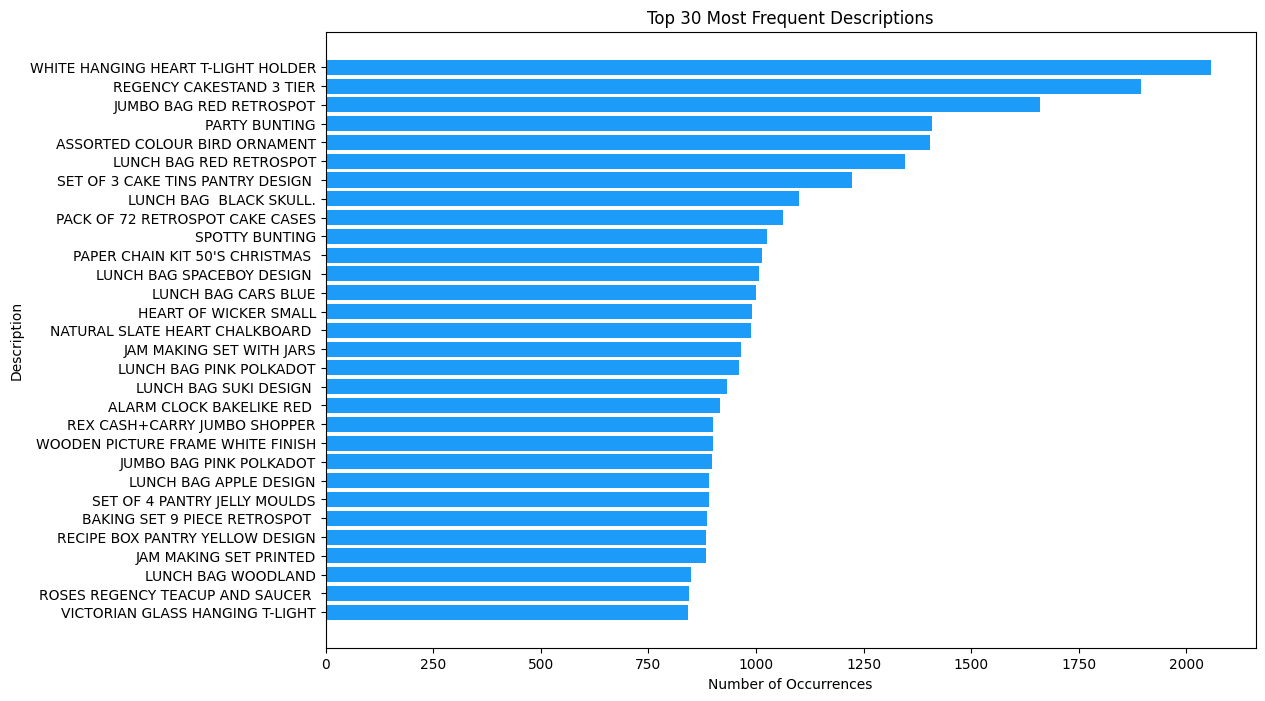

In [766]:
# Calculate the occurrence of each unique description and sort them
description_counts = df['Description'].value_counts()

# Get the top 30 descriptions
top_30_descriptions = description_counts[:30]

# Plotting
plt.figure(figsize=(12,8))
plt.barh(top_30_descriptions.index[::-1], top_30_descriptions.values[::-1], color='#1C9BF9')

# Adding labels and title
plt.xlabel('Number of Occurrences')
plt.ylabel('Description')
plt.title('Top 30 Most Frequent Descriptions')

# Show the plot
plt.show()

In [767]:
# Finding unique descriptions containing lowercase letters
lowercase_descriptions = df['Description'].unique()
lowercase_descriptions = [desc for desc in lowercase_descriptions if any(c.islower() for c in str(desc))]

print("Unique descriptions containing lowercase letters:")
print("-" * 50)
for desc in lowercase_descriptions:
    print(desc)

Unique descriptions containing lowercase letters:
--------------------------------------------------
BAG 500g SWIRLY MARBLES
POLYESTER FILLER PAD 45x45cm
POLYESTER FILLER PAD 45x30cm
POLYESTER FILLER PAD 40x40cm
FRENCH BLUE METAL DOOR SIGN No
BAG 250g SWIRLY MARBLES
BAG 125g SWIRLY MARBLES
3 TRADITIONAl BISCUIT CUTTERS  SET
NUMBER TILE COTTAGE GARDEN No
FOLK ART GREETING CARD,pack/12
ESSENTIAL BALM 3.5g TIN IN ENVELOPE
POLYESTER FILLER PAD 65CMx65CM
NUMBER TILE VINTAGE FONT No 
POLYESTER FILLER PAD 30CMx30CM
POLYESTER FILLER PAD 60x40cm
FLOWERS HANDBAG blue and orange
Next Day Carriage
THE KING GIFT BAG 25x24x12cm
High Resolution Image


In [768]:
# Calculating the number and percentage of records with service descriptions
service_descriptions = ["Next Day Carriage", "High Resolution Image"]

number_service_descriptions = df[df['Description'].isin(service_descriptions)].shape[0]
percentage_service_descriptions = (number_service_descriptions / df.shape[0]) * 100
print(f"Number of records with service descriptions: {number_service_descriptions}")
print(f"Percentage of records with service descriptions: {percentage_service_descriptions:.2f}%")

# Removing rows with descriptions containing service descriptions
df = df[~df['Description'].isin(service_descriptions)]

Number of records with service descriptions: 83
Percentage of records with service descriptions: 0.02%


In [769]:
df.shape[0]

399606

## Inferences

- The most frequent descriptions are generally household items, particularly those associated with kitchenware, lunch bags, and decorative items.

- All the descriptions are in uppercase, which might be a standardized format for entering product descriptions in the database. It would be prudent to check if there are descriptions entered in lowercase or a mix of case styles.

- Upon reviewing the descriptions that contain lowecase characters, it is evident that some entries are not product descriptions, such as "Next Day Carriage" and "High Resolution Image". Therefore, we removed rows with this descriptions.

## Comparing Stock Codes with Descriptions

In [770]:
# Unique values in each column
{columns: len(df[columns].unique()) for columns in df.columns}

{'Invoice': 21784,
 'StockCode': 3674,
 'Description': 3886,
 'Quantity': 432,
 'InvoiceDate': 20132,
 'Price': 370,
 'Customer ID': 4363,
 'Country': 37,
 'Transaction_Status': 2}

In [771]:
# Ensure columns are of type string
df['StockCode'] = df['StockCode'].astype(str)
df['Description'] = df['Description'].astype(str)

# Count how many StockCode are associated with each Description
description_counts = df.groupby('Description')['StockCode'].nunique().reset_index()
description_counts.rename(columns={'StockCode': 'StockCode_Count'}, inplace=True)

# Filter descriptions shared by more than one StockCode
shared_descriptions = description_counts[description_counts['StockCode_Count'] > 1]

# Show shared descriptions
print("Descriptions shared by multiple StockCodes:")
print("-" * 50)
print(shared_descriptions)

# Get details of the StockCode associated with these Descriptions
shared_desc_details = df[df['Description'].isin(shared_descriptions['Description'])][['StockCode', 'Description']].drop_duplicates().sort_values(by='Description')

# Show details
print("\nStockCode details with shared descriptions:")
print("-" * 50)
print(shared_desc_details)

Descriptions shared by multiple StockCodes:
--------------------------------------------------
                          Description  StockCode_Count
827      COLOURING PENCILS BROWN TUBE                2
829        COLUMBIAN CANDLE RECTANGLE                2
830            COLUMBIAN CANDLE ROUND                2
1080  EAU DE NILE JEWELLED PHOTOFRAME                2
1324     FRENCH FLORAL CUSHION COVER                 2
1327    FRENCH LATTICE CUSHION COVER                 2
1345              FROSTED WHITE BASE                 2
2018   METAL SIGN,CUPCAKE SINGLE HOOK                3
2332  PAPER LANTERN 9 POINT SNOW STAR                2
2461    PINK FAIRY CAKE CUSHION COVER                2
2466    PINK FLOCK GLASS CANDLEHOLDER                2
2472       PINK FLOWERS RABBIT EASTER                2
2796          RETRO PLASTIC 70'S TRAY                2
2797         RETRO PLASTIC DAISY TRAY                2
2799         RETRO PLASTIC POLKA TRAY                2
2872     ROUND BLUE CLOCK

In [772]:
# Convert StockCode to string
df['StockCode'] = df['StockCode'].astype(str)

# Group by StockCode and count the uniques Descriptions
stock_code_description = df.groupby('StockCode')['Description'].nunique().reset_index()
stock_code_description.rename(columns={'Description': 'Unique_Descriptions_Count'}, inplace= True)

# Filtering the stock codes with more than 1 unique description
multiple_descriptions = stock_code_description[stock_code_description['Unique_Descriptions_Count'] > 1]

# Displaying the stock codes with more than 1 unique description
print("Stock codes with more than 1 unique description:")
print("-" * 50)

print(multiple_descriptions)

# Obtaining the details of the stock codes with more than 1 unique description
multiple_descriptions_details = multiple_descriptions['StockCode']
details = df[df['StockCode'].isin(multiple_descriptions_details)][['StockCode', 'Description']].drop_duplicates().sort_values(by='StockCode')

print("\nDetails of the stock codes with more than 1 unique description:")
print("-" * 50)
print(details)

Stock codes with more than 1 unique description:
--------------------------------------------------
     StockCode  Unique_Descriptions_Count
42      16156L                          2
100     17107D                          3
118      20622                          2
170      20725                          2
262      20914                          2
...        ...                        ...
3308    85184C                          2
3309    85185B                          2
3372    90014A                          2
3373    90014B                          2
3374    90014C                          2

[213 rows x 2 columns]

Details of the stock codes with more than 1 unique description:
--------------------------------------------------
       StockCode                          Description
47284     16156L                       WRAP, CAROUSEL
138080    16156L                        WRAP CAROUSEL
315743    17107D         FLOWER FAIRY 5 DRAWER LINERS
347764    17107D    FLOWER FAIRY 5 SUMME

In [773]:
{columns: len(df[columns].unique()) for columns in df.columns}

{'Invoice': 21784,
 'StockCode': 3674,
 'Description': 3886,
 'Quantity': 432,
 'InvoiceDate': 20132,
 'Price': 370,
 'Customer ID': 4363,
 'Country': 37,
 'Transaction_Status': 2}

In [774]:
import pandas as pd

# Ensure columns are of type string
df['StockCode'] = df['StockCode'].astype(str)
df['Description'] = df['Description'].astype(str)

# Step 1: Unify multiple descriptions by selecting the most frequent one
most_frequent_desc = df.groupby(['StockCode', 'Description']).size().reset_index(name='Count')
most_frequent_desc = most_frequent_desc.sort_values(['StockCode', 'Count'], ascending=[True, False])
most_frequent_desc = most_frequent_desc.groupby('StockCode').first().reset_index()[['StockCode', 'Description']]

# Update the DataFrame with unified descriptions
df = df.drop(columns=['Description']).merge(most_frequent_desc, on='StockCode', how='left')

# Step 2: Identify and modify shared descriptions
description_counts = df.groupby('Description')['StockCode'].nunique().reset_index()
shared_descriptions = description_counts[description_counts['StockCode'] > 1]['Description']

# Modify shared descriptions by adding the StockCode
df.loc[df['Description'].isin(shared_descriptions), 'Description'] = (
    df['Description'] + " (" + df['StockCode'] + ")"
)

# Step 3: Validate results
# Verify unique values
print("Unique values after cleaning:")
print(f"StockCode: {df['StockCode'].nunique()}")
print(f"Description: {df['Description'].nunique()}")

# Check multiple descriptions
stock_code_description = df.groupby('StockCode')['Description'].nunique().reset_index()
multiple_descriptions = stock_code_description[stock_code_description['Description'] > 1]
if multiple_descriptions.empty:
    print("No StockCode with multiple descriptions.")
else:
    print("Warning: Some StockCode still have multiple descriptions:")
    print(multiple_descriptions)

# Check shared descriptions
description_counts = df.groupby('Description')['StockCode'].nunique().reset_index()
shared_descriptions = description_counts[description_counts['StockCode'] > 1]
if shared_descriptions.empty:
    print("There are no descriptions shared by multiple StockCode.")
else:
    print("Warning: Some descriptions are still shared:")
    print(shared_descriptions)

Unique values after cleaning:
StockCode: 3674
Description: 3674
No StockCode with multiple descriptions.
There are no descriptions shared by multiple StockCode.


## Inferences:

- **StockCodes with multiple Descriptions:** 213 StockCodes have multiple descriptions (196 with 2, 15 with 3, 2 with 4), causing extra Description values
- **Descriptions shared by multiple StockCodes:** 19 descriptions are used by 39 StockCodes

The presence of multiple descriptions per StockCode and shared descriptions across StockCode led to data quality issues, complicating product-level analyses such as identifying top-selling items.

### Strategy:

- For the 213 StockCodes with multiple descriptions, we selected the most frequent Description for each StockCode using a group-by operation and sorting by count.
- For the 19 descriptions shared across 39 StockCode, we appended the StockCode in parentheses to create unique descriptions (e.g., "COLOURING PENCILS BROWN TUBE (10133)" and "COLOURING PENCILS BROWN TUBE (10135)").

## Treating Zero Unit Prices

### 

In [775]:
df['Price'].describe()

count    399606.000000
mean          2.904957
std           4.448796
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max         649.500000
Name: Price, dtype: float64

In [776]:
df[df['Price']==0].describe()[['Quantity']]

,Quantity
count,33.000000
mean,420.515152
min,1.000000
25%,2.000000
50%,11.000000
75%,36.000000
max,12540.000000
std,2176.713608


In [777]:
df[df['Price']==0].head(10)

,Invoice,StockCode,Quantity,InvoiceDate,Price,Customer ID,Country,Transaction_Status,Description
6816,537197,22841,1,2010-12-05 14:02:00,0.0,12647.0,Germany,Completed,ROUND CAKE TIN VINTAGE GREEN
22536,539263,22580,4,2010-12-16 14:36:00,0.0,16560.0,United Kingdom,Completed,ADVENT CALENDAR GINGHAM SACK
25442,539722,22423,10,2010-12-21 13:45:00,0.0,14911.0,EIRE,Completed,REGENCY CAKESTAND 3 TIER
29243,540372,22090,24,2011-01-06 16:41:00,0.0,13081.0,United Kingdom,Completed,PAPER BUNTING RETROSPOT
29245,540372,22553,24,2011-01-06 16:41:00,0.0,13081.0,United Kingdom,Completed,PLASTERS IN TIN SKULLS
34743,541109,22168,1,2011-01-13 15:10:00,0.0,15107.0,United Kingdom,Completed,ORGANISER WOOD ANTIQUE WHITE
54228,543599,84535B,16,2011-02-10 13:08:00,0.0,17560.0,United Kingdom,Completed,FAIRY CAKES NOTEBOOK A6 SIZE
86338,547417,22062,36,2011-03-23 10:25:00,0.0,13239.0,United Kingdom,Completed,CERAMIC BOWL WITH LOVE HEART DESIGN
93491,548318,22055,5,2011-03-30 12:45:00,0.0,13113.0,United Kingdom,Completed,MINI CAKE STAND HANGING STRAWBERY
98139,548871,22162,2,2011-04-04 14:42:00,0.0,14410.0,United Kingdom,Completed,HEART GARLAND RUSTIC PADDED


In [778]:
# Removing records with a unit price of zero to avoid potential data entry errors
df = df[df['Price'] > 0]

In [779]:
# Resetting the index of the cleaned dataset
df.reset_index(drop=True, inplace=True)

# Getting the number of rows in the dataframe
df.shape[0]

399573

## Inferences

- The transactions with a unit price of zero are relatively few in number (33 transactions).
- These transactions have a large variability in the quantity of items involved, ranging from 1 to 12540, with a substantial standard deviation.

Given the small number of these transactions and their potential to introduce noise in the data analysis, the strategy should be to remove these transactions from the dataset.

# Feature Engineering

In [780]:
# Total price of each transaction
df['TotalPrice'] = df['Quantity'] * df['Price']
df.head()

,Invoice,StockCode,Quantity,InvoiceDate,Price,Customer ID,Country,Transaction_Status,Description,TotalPrice
0,536365,85123A,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,Completed,WHITE HANGING HEART T-LIGHT HOLDER,15.30
1,536365,71053,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Completed,WHITE METAL LANTERN,20.34
2,536365,84406B,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,Completed,CREAM CUPID HEARTS COAT HANGER,22.00
3,536365,84029G,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Completed,KNITTED UNION FLAG HOT WATER BOTTLE,20.34
4,536365,84029E,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Completed,RED WOOLLY HOTTIE WHITE HEART.,20.34


In [781]:
# First and last date of the dataset
print("Min Date", df["InvoiceDate"].min(), "Max Date", df["InvoiceDate"].max())

Min Date 2010-12-01 08:26:00 Max Date 2011-12-09 12:50:00


## Customer Behavioral Features (RFM)

## Recency

This metric indicates how recently a customer has made a purchase. A lower recency value means the customer has purchased more recently, indicating higher engagement with the brand.

In [782]:
# Recency calculation and customer data creation
today_date = df.agg({"InvoiceDate":"max"})

# Calculate the number of days since the last purchase
customer_data = (today_date - df.groupby("Customer ID") \
           .agg({"InvoiceDate":"max"})) \
            .rename(columns = {"InvoiceDate":"Recency"})

customer_data["Recency"] = customer_data["Recency"] \
    .apply(lambda x: x.days)

customer_data.head()

,Recency
Customer ID,
12346.0,325
12347.0,1
12348.0,74
12349.0,18
12350.0,309


## Frecuency

There are two features that quantify the frequency of a customer's engagement with the retailer:

- **Total Transactions:** This feature represents the total number of transactions made by a customer. It helps in understanding the engagement level of a customer with the retailer.

- **Total Products Purchased:** This feature indicates the total number of products (sum of quantities) purchased by a customer across all transactions. It gives an insight into the customer's buying behavior in terms of the volume of products purchased.

In [783]:
# Calculate the total number of transactions made by each customer
total_transactions = df.groupby('Customer ID')['Invoice'] \
                    .nunique() \
                        .reset_index()
total_transactions.rename(columns={'Invoice': 'Total_Transactions'}, inplace=True)

# Calculate the total number of products purchased by each customer
total_products_purchased = df.groupby('Customer ID')['Quantity'] \
                            .sum() \
                                .reset_index()
total_products_purchased.rename(columns={'Quantity': 'Total_Products_Purchased'}, inplace=True)

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, total_transactions, on='Customer ID')
customer_data = pd.merge(customer_data, total_products_purchased, on='Customer ID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,Customer ID,Recency,Total_Transactions,Total_Products_Purchased
0,12346.0,325,2,0
1,12347.0,1,7,2458
2,12348.0,74,4,2332
3,12349.0,18,1,630
4,12350.0,309,1,196


## Monetary

There are two features that represent the monetary aspect of customer's transactions:

- **Total Spend:** This feature represents the total amount of money spent by each customer. It is calculated as the sum of the product of UnitPrice and Quantity for all transactions made by a customer. This feature is crucial as it helps in identifying the total revenue generated by each customer, which is a direct indicator of a customer's value to the business.

- **Average Transaction Value:** This feature is calculated as the **Total Spend** divided by the Total Transactions for each customer. It indicates the average value of a transaction carried out by a customer. This metric is useful in understanding the spending behavior of customers per transaction, which can assist in tailoring marketing strategies and offers to different customer segments based on their average spending patterns.

In [784]:
# Calculate the total spend by each customer
total_spend = df.groupby('Customer ID')['TotalPrice'] \
            .sum() \
                .reset_index()

total_spend.rename(columns={'TotalPrice': 'Total_Spend'}, inplace=True)

# Calculate the average transaction value for each customer
average_transaction_value = total_spend.merge(total_transactions, on='Customer ID')
average_transaction_value['Average_Transaction_Value'] = average_transaction_value['Total_Spend'] / average_transaction_value['Total_Transactions']

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, total_spend, on='Customer ID')
customer_data = pd.merge(customer_data, average_transaction_value[['Customer ID', 'Average_Transaction_Value']], on='Customer ID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,Customer ID,Recency,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value
0,12346.0,325,2,0,0.00,0.000000
1,12347.0,1,7,2458,4310.00,615.714286
2,12348.0,74,4,2332,1437.24,359.310000
3,12349.0,18,1,630,1457.55,1457.550000
4,12350.0,309,1,196,294.40,294.400000


In [785]:
# Calculate the number of unique products purchased by each customer
unique_products_purchased = df.groupby('Customer ID')['StockCode'] \
                            .nunique() \
                                .reset_index()
unique_products_purchased.rename(columns={'StockCode': 'Unique_Products_Purchased'}, inplace=True)

# Merge the new feature into the customer_data dataframe
customer_data = pd.merge(customer_data, unique_products_purchased, on='Customer ID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,Customer ID,Recency,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased
0,12346.0,325,2,0,0.00,0.000000,1
1,12347.0,1,7,2458,4310.00,615.714286,103
2,12348.0,74,4,2332,1437.24,359.310000,21
3,12349.0,18,1,630,1457.55,1457.550000,72
4,12350.0,309,1,196,294.40,294.400000,16


## Cancellation Insights

- **Cancellation Frequency:** This metric represents the total number of transactions a customer has canceled. Understanding the frequency of cancellations can help us identify customers who are more likely to cancel transactions. This could be an indicator of dissatisfaction or other issues, and understanding this can help us tailor strategies to reduce cancellations and enhance customer satisfaction.

- **Cancellation Rate:** This represents the proportion of transactions that a customer has canceled out of all their transactions. This metric gives a normalized view of cancellation behavior. A high cancellation rate might be indicative of an unsatisfied customer segment. By identifying these segments, we can develop targeted strategies to improve their shopping experience and potentially reduce the cancellation rate.

In [786]:
# Calculate the total number of transactions made by each customer
total_transactions = df.groupby('Customer ID')['Invoice'].nunique().reset_index()

# Calculate the number of cancelled transactions for each customer
cancelled_transactions = df[df['Transaction_Status'] == 'Cancelled']
cancellation_frequency = cancelled_transactions.groupby('Customer ID')['Invoice'].nunique().reset_index()
cancellation_frequency.rename(columns={'Invoice': 'Cancellation_Frequency'}, inplace=True)

# Merge the Cancellation Frequency data into the customer_data dataframe
customer_data = pd.merge(customer_data, cancellation_frequency, on='Customer ID', how='left')

# Replace NaN values with 0 (for customers who have not cancelled any transaction)
customer_data['Cancellation_Frequency'].fillna(0, inplace=True)

# Calculate the Cancellation Rate
customer_data['Cancellation_Rate'] = customer_data['Cancellation_Frequency'] / total_transactions['Invoice']

# Display the first few rows of the customer_data dataframe
customer_data.head()

,Customer ID,Recency,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Cancellation_Frequency,Cancellation_Rate
0,12346.0,325,2,0,0.00,0.000000,1,1.0,0.5
1,12347.0,1,7,2458,4310.00,615.714286,103,0.0,0.0
2,12348.0,74,4,2332,1437.24,359.310000,21,0.0,0.0
3,12349.0,18,1,630,1457.55,1457.550000,72,0.0,0.0
4,12350.0,309,1,196,294.40,294.400000,16,0.0,0.0


In [787]:
# Number of customers who cancelled at least one transaction
customers_who_cancelled = customer_data[customer_data['Cancellation_Rate'] > 0]
print(f"Number of customers who cancelled at least one transaction: {customers_who_cancelled.shape[0]}")
customers_who_cancelled.head(15)

Number of customers who cancelled at least one transaction: 1534


,Customer ID,Recency,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Cancellation_Frequency,Cancellation_Rate
0,12346.0,325,2,0,0.00,0.000000,1,1.0,0.500000
5,12352.0,35,8,463,1265.41,158.176250,57,1.0,0.125000
12,12359.0,7,6,1599,6182.98,1030.496667,214,2.0,0.333333
15,12362.0,2,13,2180,4665.58,358.890769,200,3.0,0.230769
25,12375.0,2,3,175,375.42,125.140000,13,1.0,0.333333
28,12379.0,81,3,401,775.29,258.430000,38,1.0,0.333333
29,12380.0,21,5,1109,2423.56,484.712000,76,1.0,0.200000
30,12381.0,4,4,772,1433.46,358.365000,69,1.0,0.250000
31,12383.0,184,6,1515,1617.31,269.551667,83,1.0,0.166667
32,12384.0,28,3,117,406.16,135.386667,25,1.0,0.333333


## Seasonality

The seasonality in customers' purchasing behaviors can offer invaluable insights for tailoring marketing strategies and enhancing customer satisfaction. Here are the two features to introduce:

- **Monthly_Spending_Mean:** This is the average amount a customer spends monthly. It helps us gauge the general spending habit of each customer. A higher mean indicates a customer who spends more, potentially showing interest in premium products, whereas a lower mean might indicate a more budget-conscious customer.

- **Monthly_Spending_Std:** This feature indicates the variability in a customer's monthly spending. A higher value signals that the customer's spending fluctuates significantly month-to-month, perhaps indicating sporadic large purchases. In contrast, a lower value suggests more stable, consistent spending habits. Understanding this variability can help in crafting personalized promotions or discounts during periods they are expected to spend more.

In [788]:
# Extract month and year from InvoiceDate
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month

# Calculate monthly spending for each customer
monthly_spending = df.groupby(['Customer ID', 'Year', 'Month'])['TotalPrice'].sum().reset_index()

# Calculate Seasonal Buying Patterns: We are using monthly frequency as a proxy for seasonal buying patterns
seasonal_buying_patterns = monthly_spending.groupby('Customer ID')['TotalPrice'].agg(['mean', 'std']).reset_index()
seasonal_buying_patterns.rename(columns={'mean': 'Monthly_Spending_Mean', 'std': 'Monthly_Spending_Std'}, inplace=True)

# Replace NaN values in Monthly_Spending_Std with 0, implying no variability for customers with single transaction month
seasonal_buying_patterns['Monthly_Spending_Std'].fillna(0, inplace=True)

# Remove the Year and Month columns from the original dataframe
df.drop(columns=['Year', 'Month'], inplace=True)

In [789]:
# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, seasonal_buying_patterns, on='Customer ID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,Customer ID,Recency,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std
0,12346.0,325,2,0,0.00,0.000000,1,1.0,0.5,0.000000,0.000000
1,12347.0,1,7,2458,4310.00,615.714286,103,0.0,0.0,615.714286,341.070789
2,12348.0,74,4,2332,1437.24,359.310000,21,0.0,0.0,359.310000,203.875689
3,12349.0,18,1,630,1457.55,1457.550000,72,0.0,0.0,1457.550000,0.000000
4,12350.0,309,1,196,294.40,294.400000,16,0.0,0.0,294.400000,0.000000


## Customer Dataset Description

| **Feature**                    | **Description**                                                                                      |
|-------------------------------|------------------------------------------------------------------------------------------------------|
| Customer ID                   | Identifier uniquely assigned to each customer, used to distinguish individual customers.             |
| Recency                       | The number of days that have passed since the customer's last purchase.                             |
| Total_Transactions            | The total number of transactions made by the customer.                                              |
| Total_Products_Purchased      | The total quantity of products purchased by the customer across all transactions.                   |
| Total_Spend                   | The total amount of money the customer has spent across all transactions.                           |
| Average_Transaction_Value     | The average value of the customer's transactions, calculated as total spend divided by transactions. |
| Unique_Products_Purchased     | The number of different products the customer has purchased.                                        |
| Cancellation_Frequency        | The total number of transactions that the customer has cancelled.                                   |
| Cancellation_Rate             | The proportion of transactions that the customer has cancelled, calculated as cancellations/total.  |
| Monthly_Spending_Mean         | The average monthly spending of the customer.                                                       |
| Monthly_Spending_Std          | The standard deviation of the customer's monthly spending, indicating variability.                  |


## Outlier Detection

**Isolation Forest** algorithm works well for multi-dimensional data and is computationally efficient. It isolates observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

In [790]:
# Calcular estadísticas descriptivas
stats = customer_data[['Recency', 'Total_Transactions', 'Total_Spend', 'Cancellation_Rate']].describe().T
stats['median'] = customer_data[['Total_Spend', 'Cancellation_Rate', 'Recency']].median()
stats = stats[['mean', 'median', 'std', 'min', 'max']]
print(stats.round(2))

                       mean  median      std     min        max
Recency               91.17   49.00   100.97     0.0     373.00
Total_Transactions     4.99     NaN     9.08     1.0     242.00
Total_Spend         1894.60  641.78  8266.05 -1192.2  278778.02
Cancellation_Rate      0.11    0.00     0.18     0.0       1.00


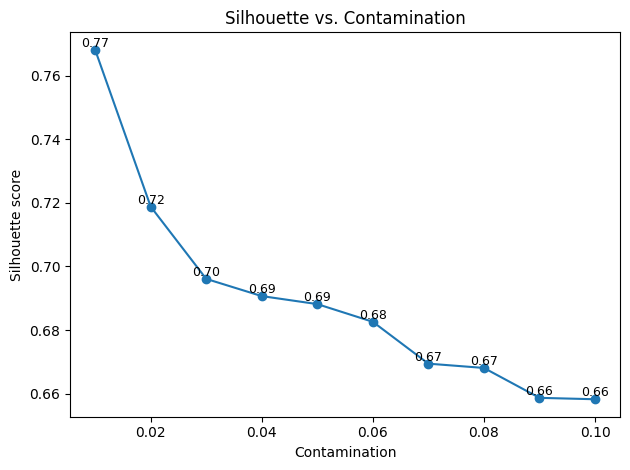

In [791]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

# Select features for anomaly detection
X = customer_data[['Recency', 'Total_Transactions', 'Total_Spend', 'Cancellation_Rate']]

# Visualize the process of finding the optimal number of percentage of contamination
contaminations = np.linspace(0.01, 0.10, 10)
scores = []

for c in contaminations:
    iso = IsolationForest(contamination=c, random_state=0)
    mask = iso.fit_predict(X) == 1
    km = KMeans(n_clusters=3, random_state=0).fit(X[mask])
    scores.append(silhouette_score(X[mask], km.labels_))

# Plot
plt.plot(contaminations, scores, marker='o')
for x, y in zip(contaminations, scores):
    plt.text(x, y, f"{y:.2f}", ha='center', va='bottom', fontsize=9)

plt.xlabel("Contamination")
plt.ylabel("Silhouette score")
plt.title("Silhouette vs. Contamination")
plt.tight_layout()
plt.show()

In [792]:
# Fit the Isolation Forest model
model = IsolationForest(contamination=0.01, random_state=42)
model.fit(X)

# Predict anomalies
anomalies = model.predict(X)
anomalies = pd.Series(anomalies, index=customer_data.index)
customer_data['Outlier'] = anomalies
customer_data['Outlier'] = customer_data['Outlier'].map({1: 0, -1: 1})  # Convert to binary (0 for normal, 1 for anomaly)

# Display the first few rows of the customer_data dataframe
customer_data.head(10)

,Customer ID,Recency,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Outlier
0,12346.0,325,2,0,0.00,0.000000,1,1.0,0.500,0.000000,0.000000,0
1,12347.0,1,7,2458,4310.00,615.714286,103,0.0,0.000,615.714286,341.070789,0
2,12348.0,74,4,2332,1437.24,359.310000,21,0.0,0.000,359.310000,203.875689,0
3,12349.0,18,1,630,1457.55,1457.550000,72,0.0,0.000,1457.550000,0.000000,0
4,12350.0,309,1,196,294.40,294.400000,16,0.0,0.000,294.400000,0.000000,0
5,12352.0,35,8,463,1265.41,158.176250,57,1.0,0.125,316.352500,134.700629,0
6,12353.0,203,1,20,89.00,89.000000,4,0.0,0.000,89.000000,0.000000,0
7,12354.0,231,1,530,1079.40,1079.400000,58,0.0,0.000,1079.400000,0.000000,0
8,12355.0,213,1,240,459.40,459.400000,13,0.0,0.000,459.400000,0.000000,0
9,12356.0,22,3,1573,2487.43,829.143333,52,0.0,0.000,829.143333,991.462585,0


In [793]:
# Percentage of outliers
outlier_percentage = (customer_data['Outlier'].sum() / customer_data.shape[0]) * 100
print(f"Percentage of outliers: {outlier_percentage:.2f}%")

Percentage of outliers: 0.99%


In [794]:
# Separate outliers
outliers = customer_data[customer_data['Outlier'] == 1]

# Remove outliers from the dataset
customer_data_cleaned = customer_data[customer_data['Outlier'] == 0]

# Drop the Outlier column
customer_data_cleaned.drop(columns=['Outlier'], inplace=True)
customer_data_cleaned.reset_index(drop=True, inplace=True)

customer_data_cleaned.shape[0]

4319

## Inferences

The curve clearly shows that the higher the percentage of outliers to remove, the worse the internal "quality" of the clusters (silhouette score) becomes. Specifically:

- Maximum peak at 0.01 (≈0.78): Removing 1% of the outliers before clustering produces the most compact and well-separated clusters.

- From there, as the proportion of data removed increases, the silhouette score drops fairly steadily.

### Strategy

It is crucial to handle these outliers to prevent them from affecting the clusters' quality significantly. The strategy will be to separate these outliers for further analysis and remove them from our main dataset to prepare it for the clustering analysis.

## Correlation Analysis

Before we proceed to KMeans clustering, it's essential to check the correlation between features in our dataset. The presence of multicollinearity, where features are highly correlated, can potentially affect the clustering process by not allowing the model to learn the actual underlying patterns in the data, we can utilize dimensionality reduction techniques like PCA. These techniques help in neutralizing the effect of multicollinearity by transforming the correlated features into a new set of uncorrelated variables, preserving most of the original data's variance.

In [795]:
from plotly import express as px

# Calcular la matriz de correlación (redondeada)
corr = customer_data_cleaned.drop(columns=['Customer ID']).corr().round(2)

# Crear máscara para mantener solo la mitad inferior
mask = np.triu(np.ones(corr.shape), k=1).astype(bool)
corr_masked = corr.mask(mask)

# Crear heatmap
fig = px.imshow(
    corr_masked,
    text_auto=True,
    color_continuous_scale=["#ffffff", "#1C9BF9"],
    aspect="equal",
    labels=dict(x="", y="", color="Correlación")
)

# Personalizar layout
fig.update_layout(
    width=900,
    height=900,
    xaxis_side="bottom",  # Que aparezcan abajo
    font=dict(size=15),
    xaxis=dict(tickfont=dict(family="Arial", size=14)),
    yaxis=dict(tickfont=dict(family="Arial", size=14))
)

# Cambiar fuente de los números dentro del heatmap
fig.update_traces(
    textfont=dict(family="Arial", size=18),
    texttemplate="%{z:.2f}"
)

# Mantener etiquetas horizontales
fig.update_xaxes(tickangle=270)

fig.show()

### Inferences

- **Recency:** The longer the time since the customer's last purchase, the fewer transactions (-0.35), products purchased (-0.25), and money spent (-0.25). In other words, recent customers are more active.
- **Total_Transactions:** More transactions are associated with more products purchased (0.62), higher spending (0.66), greater product variety (0.55), and more cancellations (0.74). Frequent customers spend and cancel more.
- **Total_Products_Purchased:** More products purchased means higher spending (0.84) and greater variety (0.45). This is associated with a higher value per transaction (0.35) and less time since the last purchase (-0.25).
- **Total_Spend:** Higher total spending is associated with higher transaction value (0.49), more unique products (0.50), and higher average (0.59) and variable (0.63) monthly spending. High spenders purchased recently (-0.25).
- **Average_Transaction_Value:** Higher transaction value is closely linked to average monthly spending (0.81). It has no clear relationship with recency (-0.04) or transactions (0.00).
- **Unique_Products_Purchased:** Greater product variety is associated with more cancellations (0.36) and recent purchases (-0.34). It also has a significant link to monthly spending (0.19).
- **Cancellation_Frequency:** More cancellations are linked to more transactions (0.74) and a higher cancellation rate (0.60). Customers who canceled a lot purchased recently (-0.22).
- **Cancellation_Rate:** It has no strong relationship with other variables, except for cancellation frequency (0.60). It is independent of spending or recency (-0.06).
- **Monthly_Spending_Mean:** Higher monthly spending is associated with higher total spending (0.59), higher transaction value (0.81), and spending variability (0.40). It reflects active customers.
- **Monthly_Spending_Std:** Higher spending variability is associated with higher total spending (0.63) and average monthly spending (0.40). Customers with variable spending purchased recently (-0.14).

## Standard Scaler Application

K-means relies heavily on the concept of 'distance' between data points to form clusters. When features are not on a similar scale, features with larger values can disproportionately influence the clustering outcome, potentially leading to incorrect groupings. That's why data must be standardized.

In [796]:
from sklearn.preprocessing import StandardScaler

# Feature selection
RFM_features = ['Customer ID','Recency', 'Total_Transactions', 'Total_Spend']
customer_RFM = customer_data_cleaned[RFM_features]

# Initialize the StandardScaler
scaler = StandardScaler()

# List of columns that don't need to be scaled
columns_to_exclude = ['Customer ID']

# List of columns that need to be scaled
columns_to_scale = customer_RFM.columns.difference(columns_to_exclude)

# Copy the cleaned dataset
customer_RFM_scaled = customer_RFM.copy()

# Applying the scaler to the necessary columns in the dataset
customer_RFM_scaled[columns_to_scale] = scaler.fit_transform(customer_RFM_scaled[columns_to_scale])

# Set 'Customer ID' as index
customer_RFM_scaled.set_index('Customer ID', inplace=True)

# Display the first few rows of the scaled data
customer_RFM_scaled.head()

,Recency,Total_Transactions,Total_Spend
Customer ID,,,
12346.0,2.343185,-0.445697,-0.540943
12347.0,-0.898409,0.428095,1.078903
12348.0,-0.168050,-0.096180,-0.000779
12349.0,-0.728325,-0.620455,0.006854
12350.0,2.183106,-0.620455,-0.430297


## Inferences

A model with fewer components may be preferable to avoid overfitting. Retaining three components is a reasonable choice, as it captures 92% of the variance with fewer dimensions, facilitating interpretation and reducing model complexity.

## Determining the Optimal Number of Clusters

To ascertain the optimal number of clusters (k) for segmenting customers, I will explore two renowned methods:

- **Elbow Method**

- **Silhouette Method**

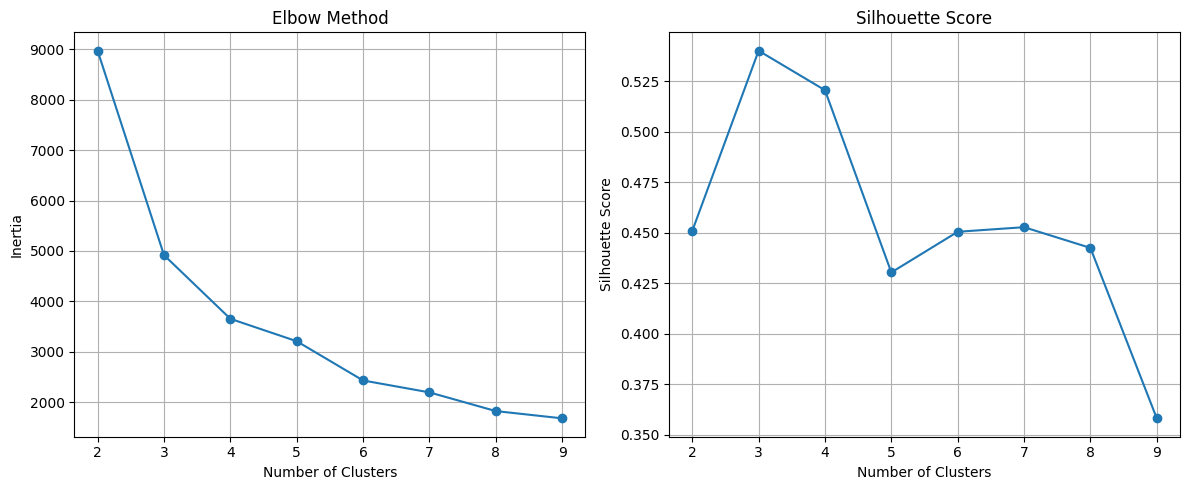

In [797]:
# Elbow method to find the optimal number of clusters
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Range of clusters to test
range_n_clusters = range(2, 10)
inertia = []
silhouette_scores = []

# Loop through the range of clusters
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(customer_RFM_scaled)
    
    # Calculate inertia
    inertia.append(kmeans.inertia_)
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(customer_RFM_scaled, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

# Plotting the elbow method
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range_n_clusters, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid()
plt.tight_layout()
plt.show()

### Inferences

**Elbow: k between 4 and 5:** The optimal number of clusters appears to be between k = 4 and k = 5, as this is where the inertia (within-cluster sum of squares) starts to level off noticeably. This "elbow" indicates diminishing returns in model improvement when adding more clusters.

**Silhouette: k = 3 clearly wins:** The silhouette score peaks at k = 3, indicating the highest cluster cohesion and separation at that point. While k = 4 also shows a high score, the performance starts to decrease beyond that.

Despite a small drop in silhouette score, 4 clusters is the best option for a RFM Segmentation

## Applying Clustering KMeans

In [798]:
from collections import Counter

# Apply KMeans clustering using the optimal k
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=100, random_state=42)
kmeans.fit(customer_RFM_scaled)

# Get the frequency of each cluster
cluster_frequencies = Counter(kmeans.labels_)

freq_sorted = cluster_frequencies.most_common()  
#    freq_sorted = [(3, 50), (1, 45), (4, 40), (0, 30), (2, 25)]

label_mapping = {old_label: new_label for new_label, (old_label, _) in enumerate(freq_sorted)}
#    label_mapping = {3:0, 1:1, 4:2, 0:3, 2:4}

# Apply that mapping to each label generated by KMeans
original_labels = kmeans.labels_                    # array([2, 0, 3, 3, 1, ...])
new_labels = np.array([label_mapping[label] for label in original_labels])

# Add the new labels to the original DataFrame
customer_RFM_scaled['cluster'] = new_labels
customer_data_cleaned['cluster'] = new_labels

customer_data_cleaned.head()

,Customer ID,Recency,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,cluster
0,12346.0,325,2,0,0.00,0.000000,1,1.0,0.5,0.000000,0.000000,1
1,12347.0,1,7,2458,4310.00,615.714286,103,0.0,0.0,615.714286,341.070789,2
2,12348.0,74,4,2332,1437.24,359.310000,21,0.0,0.0,359.310000,203.875689,0
3,12349.0,18,1,630,1457.55,1457.550000,72,0.0,0.0,1457.550000,0.000000,0
4,12350.0,309,1,196,294.40,294.400000,16,0.0,0.0,294.400000,0.000000,1


In [799]:
print(customer_data_cleaned['cluster'].value_counts().sort_index())

cluster
0    2638
1    1044
2     559
3      78
Name: count, dtype: int64


In [800]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

features = customer_RFM_scaled.values

# Calculate the metrics for K-Means clustering
kmeans_silhouette = silhouette_score(features, kmeans.labels_)
kmeans_calinski = calinski_harabasz_score(features, kmeans.labels_)
kmeans_davies = davies_bouldin_score(features, kmeans.labels_)

# Print the metrics
print("K-Means Clustering Metrics:")
print("Silhouette Score K-Means:", kmeans_silhouette)
print("Calinski-Harabasz Score K-Means:", kmeans_calinski)
print("Davies-Bouldin Score K-Means:", kmeans_davies)

K-Means Clustering Metrics:
Silhouette Score K-Means: 0.6295880459206336
Calinski-Harabasz Score K-Means: 4715.227610428386
Davies-Bouldin Score K-Means: 0.6860147014308159


In [801]:
import plotly.express as px
fig = px.scatter_3d(customer_RFM_scaled, x='Recency', y='Total_Transactions', z='Total_Spend', color='cluster')
fig.show()

In [802]:
# Print the mean values of each cluster for insights
print("Mean values of each cluster:")
print(customer_data_cleaned.groupby('cluster')[['Recency', 'Total_Transactions', 'Total_Spend']].mean())

Mean values of each cluster:
            Recency  Total_Transactions   Total_Spend
cluster                                              
0         45.840030            3.170963    887.212077
1        248.160920            1.746169    415.546398
2         20.127013           12.803220   4088.223077
3         11.461538           29.589744  14830.474615


In [803]:
# Rename the cluster column
customer_data_cleaned.rename(columns={'cluster': 'RFM'}, inplace=True)
customer_RFM_scaled.rename(columns={'cluster': 'RFM'}, inplace=True)

# Calculate the percentage of customers in each cluster
cluster_percentages = customer_data_cleaned['RFM'].value_counts(normalize=True) * 100
cluster_percentages

RFM
0    61.078953
1    24.172262
2    12.942811
3     1.805974
Name: proportion, dtype: float64

In [804]:
# Mapping dictionary
cluster_map = {
    0: 'Regular',
    1: 'Risk',
    2: 'Loyal',
    3: 'Champion'
}

# Apply mapping
customer_RFM_scaled['RFM'] = customer_RFM_scaled['RFM'].map(cluster_map)
customer_data_cleaned['RFM'] = customer_data_cleaned['RFM'].map(cluster_map)

customer_data_cleaned.head(10)

,Customer ID,Recency,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,RFM
0,12346.0,325,2,0,0.00,0.000000,1,1.0,0.500,0.000000,0.000000,Risk
1,12347.0,1,7,2458,4310.00,615.714286,103,0.0,0.000,615.714286,341.070789,Loyal
2,12348.0,74,4,2332,1437.24,359.310000,21,0.0,0.000,359.310000,203.875689,Regular
3,12349.0,18,1,630,1457.55,1457.550000,72,0.0,0.000,1457.550000,0.000000,Regular
4,12350.0,309,1,196,294.40,294.400000,16,0.0,0.000,294.400000,0.000000,Risk
5,12352.0,35,8,463,1265.41,158.176250,57,1.0,0.125,316.352500,134.700629,Regular
6,12353.0,203,1,20,89.00,89.000000,4,0.0,0.000,89.000000,0.000000,Risk
7,12354.0,231,1,530,1079.40,1079.400000,58,0.0,0.000,1079.400000,0.000000,Risk
8,12355.0,213,1,240,459.40,459.400000,13,0.0,0.000,459.400000,0.000000,Risk
9,12356.0,22,3,1573,2487.43,829.143333,52,0.0,0.000,829.143333,991.462585,Regular


### Inferences

### Evaluation Metrics

- **Silhouette Score (0.6296):** A value close to 0.65 indicates good intra-cluster cohesion and inter-cluster separation. The clustering structure is solid.
- **Calinski-Harabasz Score (4715.23):** A high value suggesting the clusters are well-defined and compact.
- **Davies-Bouldin Score (4715.23):** A low score, which confirms distinct and non-overlapping clusters.
### Clusters Interpretation

- **Champion:** Very low recency, extremely high purchase frequency, and the highest total spend. Although they represent only 1.8% of the customer base, they are the most valuable. Should be prioritized for retention and rewards.
- **Loyal:** Frequent buyers with strong spending and good recency. Representing 12.9%, they contribute consistently to revenue. Ideal candidates for loyalty programs and engagement campaigns.
- **Regular:** The largest segment (61.1%) with moderate purchase activity and average spending. They form the core base with potential to be upsold or converted into more valuable customers.
- **Risk:** High recency, low frequency, and low total spend. These customers make up 24.2% and may be on the verge of churning. Consider reactivation strategies like targeted offers or win-back campaigns.